In [1]:
!pip install alpha_vantage
!pip install statsmodels
!pip install gluonts
!pip install mxnet

In [2]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint

In [3]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx 

In [4]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'Mean Square Error is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'Mean Absolute Error is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'Root Mean Square Error is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'Mean Absolute Percentage Error is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 score is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

## Real GDP China

In [5]:
df5 = pd.read_csv(
	'https://www.econdb.com/api/series/RGDPCN/?format=csv',
	index_col='Date', parse_dates=['Date'])
df5.columns, df5.dtypes

(Index(['RGDPCN'], dtype='object'),
 RGDPCN    int64
 dtype: object)

In [6]:
df5.shape

(60, 1)

In [7]:
df5.head()

RGDPCN
Date              
2007-01-01   53480
2007-04-01   59217
2007-07-01   61099
2007-10-01   67399
2008-01-01   59640

In [8]:
df5.dtypes

RGDPCN    int64
dtype: object

In [9]:
df5.columns = ['GDP']

In [10]:
df5.index

DatetimeIndex(['2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
      

In [11]:
df5.head()

GDP
Date             
2007-01-01  53480
2007-04-01  59217
2007-07-01  61099
2007-10-01  67399
2008-01-01  59640

In [12]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2019,10,1)
test_dataset_end = datetime(2021,4,1)

In [13]:
train_data = df5[:train_dataset_end]
test_data = df5[train_dataset_end+timedelta(days=91):test_dataset_end]

In [14]:
test_data

GDP
Date              
2020-01-01  183178
2020-04-01  224847
2020-07-01  238702
2020-10-01  263509
2021-01-01  244679
2021-04-01  267701

<AxesSubplot:xlabel='Date'>

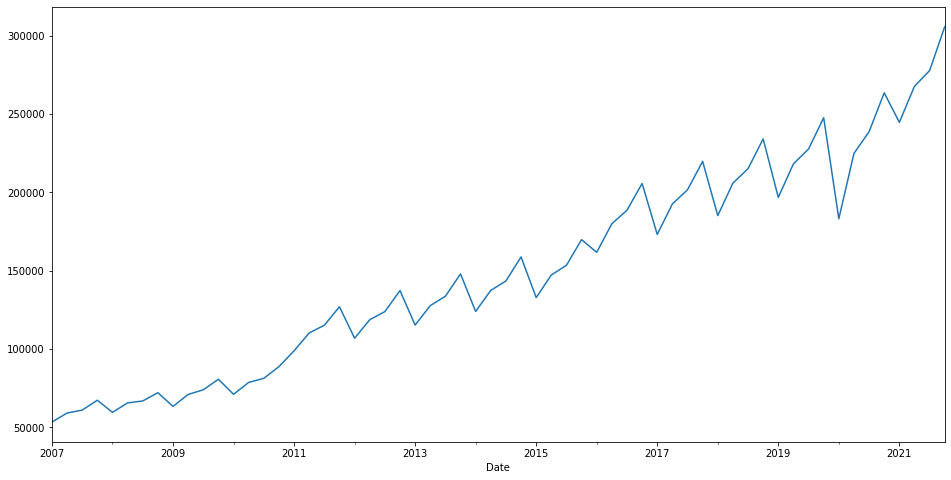

In [15]:
df5['GDP'].plot(figsize=(16,8))

In [16]:
df5['GDP differencing'] = df5['GDP'] - df5['GDP'].shift(1)  
df5['GDP second differencing'] = df5['GDP differencing'] - df5['GDP differencing'].shift(1) 

In [17]:
from statsmodels.tsa.stattools import adfuller 

In [18]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [19]:
adf_test(df5['GDP second differencing'].dropna())

ADF Statistics: -6.138428492057435
p- value: 8.080521899929281e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

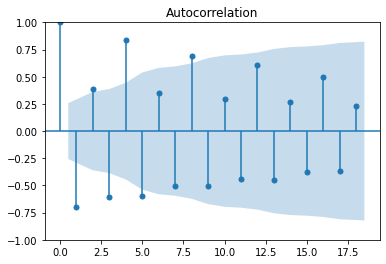

In [21]:
acf = plot_acf(df5['GDP second differencing'].dropna())

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


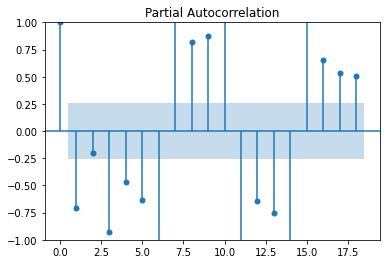

In [22]:
pacf = plot_pacf(df5['GDP second differencing'].dropna())

In [23]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA = ARIMA(train_data['GDP'], order=(15,2,4))
model_ARIMA_fit = model_ARIMA.fit()
model_ARIMA_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   52
Model:                ARIMA(15, 2, 4)   Log Likelihood                -538.902
Date:                Fri, 08 Apr 2022   AIC                           1117.805
Time:                        13:43:16   BIC                           1156.045
Sample:                    01-01-2007   HQIC                          1132.367
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9039      0.172     -5.255      0.000      -1.241      -0.567
ar.L2         -1.0685      0.250     -4.266      0.000      -1.559      -0.578
ar.L3         -0.6475      0.242     -2.676      0.007      -1.122      -0.173
ar.L4         -0.4614      0.199     -2.323      0.020      -0.851      -0.072
ar.L5         -0.5646      0.159     -3.557      0.000      -0.876      -0.253
ar.L6         -0.5060      0.169     -3.001      0.003      -0.836      -0.176
ar.L7         -0.8544      0.173     -4.939      0.000      -1.193      -0.515
ar.L8         -0.5868      0.192     -3.055      0.002      -0.963      -0.210
ar.L9         -0.6124      0.171     -3.587      0.000      -0.947      -0.278
ar.L10        -0.5722      0.178     -3.220      0.001      -0.920      -0.224
ar.L11        -0.6476      0.232     -2.789      0.005      -1.103      -0.193
ar.L12        -0.7618      0.219     -3.473      0.001      -1.192      -0.332
ar.L13        -0.6640      0.246     -2.695      0.007      -1.147      -0.181
ar.L14        -0.5630      0.172     -3.272      0.001      -0.900      -0.226
ar.L15        -0.4789      0.101     -4.729      0.000      -0.677      -0.280
ma.L1         -0.3613      1.334     -0.271      0.786      -2.975       2.253
ma.L2         -0.2061      0.719     -0.287      0.774      -1.615       1.203
ma.L3         -0.9197      0.666     -1.382      0.167      -2.225       0.385
ma.L4          0.4886      0.158      3.092      0.002       0.179       0.798
sigma2       2.68e+07   4.62e-08   5.81e+14      0.000    2.68e+07    2.68e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                17.51
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.07
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [24]:
# prediction 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2020-01-01 00:00:00
2021-04-01 00:00:00


In [25]:
pred=model_ARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['GDP']-pred

In [26]:
pred

2020-01-01    226330.295236
2020-04-01    240114.385632
2020-07-01    242333.772408
2020-10-01    266118.815442
2021-01-01    241962.349695
2021-04-01    252185.595034
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [27]:
residuals

Date
2020-01-01   -43152.295236
2020-04-01   -15267.385632
2020-07-01    -3631.772408
2020-10-01    -2609.815442
2021-01-01     2716.650305
2021-04-01    15515.404966
dtype: float64

<AxesSubplot:ylabel='Density'>

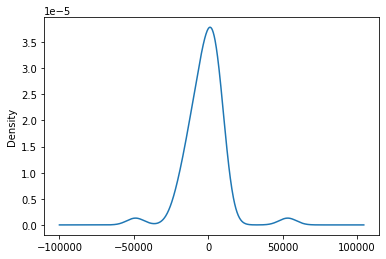

In [28]:
model_ARIMA_fit.resid.plot(kind='kde')

In [29]:
test_data['Predicted_ARIMA'] = pred

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/284031954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<AxesSubplot:xlabel='Date'>

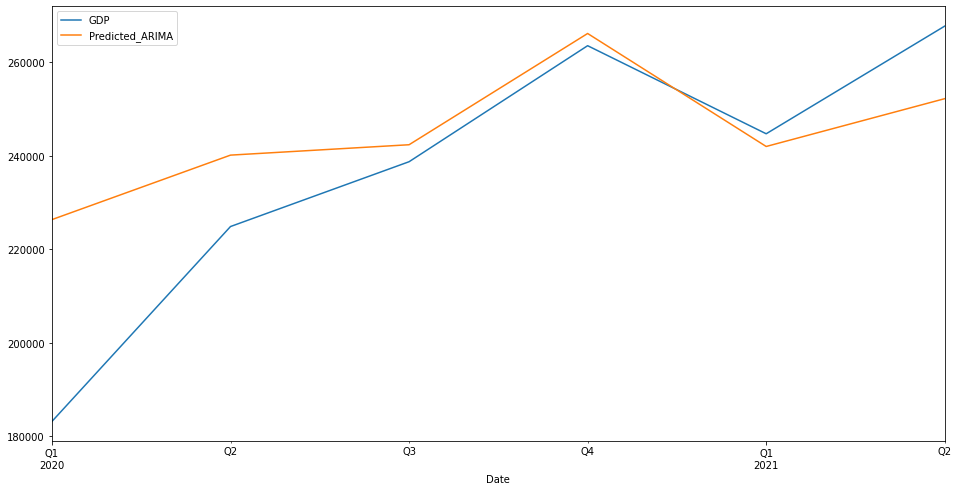

In [30]:
test_data[['GDP', 'Predicted_ARIMA']].plot(figsize=(16,8))

In [31]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
df5['GDP yearly differencing'] = df5['GDP'] - df5['GDP'].shift(4) # yearly = 4*quarterly  


/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


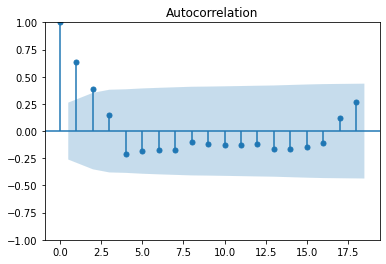

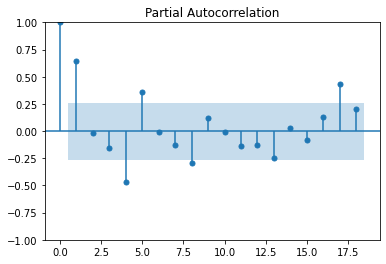

In [33]:
acf12 = plot_acf(df5['GDP yearly differencing'].dropna())
pacf12 = plot_pacf(df5['GDP yearly differencing'].dropna())

In [34]:
model_SARIMAX = SARIMAX(train_data['GDP'], order=(11,1,0), seasonal_order=(0,0,0,4))
model_SARIMAX_fit = model_SARIMAX.fit()
model_SARIMAX_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20910D+01    |proj g|=  3.89574D+00

At iterate    5    f=  1.05889D+01    |proj g|=  1.05565D-01

At iterate   10    f=  1.05810D+01    |proj g|=  1.98849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     13     14      1     0     0   2.110D-04   1.058D+01
  F =   10.580974247267177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   52
Model:              SARIMAX(11, 1, 0)   Log Likelihood                -550.211
Date:                Fri, 08 Apr 2022   AIC                           1124.421
Time:                        13:43:17   BIC                           1147.603
Sample:                    01-01-2007   HQIC                          1133.280
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0670      0.131     -0.512      0.608      -0.323       0.189
ar.L2         -0.0373      0.184     -0.203      0.839      -0.398       0.323
ar.L3         -0.0878      0.153     -0.574      0.566      -0.387       0.212
ar.L4          0.4338      0.024     18.353      0.000       0.388       0.480
ar.L5         -0.0191      0.170     -0.113      0.910      -0.351       0.313
ar.L6         -0.0147      0.248     -0.059      0.953      -0.502       0.472
ar.L7         -0.0081      0.212     -0.038      0.969      -0.424       0.408
ar.L8          0.2777      0.049      5.673      0.000       0.182       0.374
ar.L9          0.0435      0.238      0.182      0.855      -0.424       0.511
ar.L10         0.0534      0.301      0.178      0.859      -0.536       0.643
ar.L11         0.0512      0.283      0.181      0.857      -0.504       0.606
sigma2      4.468e+07    4.4e-09   1.02e+16      0.000    4.47e+07    4.47e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                53.40
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -1.76
Prob(H) (two-sided):                  0.24   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.89e+31. Standard errors may be unstable.
"""

In [35]:
pred_SARIMAX = model_SARIMAX_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['GDP'] - pred_SARIMAX

<AxesSubplot:xlabel='Date'>

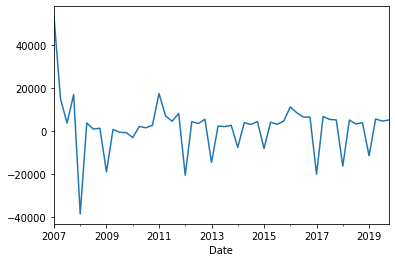

In [36]:
model_SARIMAX_fit.resid.plot()

<AxesSubplot:ylabel='Density'>

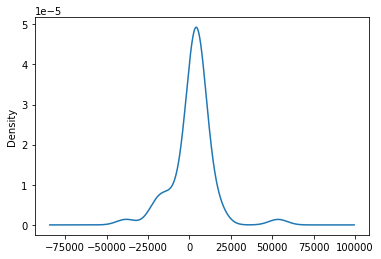

In [37]:
model_SARIMAX_fit.resid.plot(kind='kde')

In [38]:
test_data['Predicted_SARIMAX'] = pred_SARIMAX

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/1953269687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMAX'] = pred_SARIMAX


<AxesSubplot:xlabel='Date'>

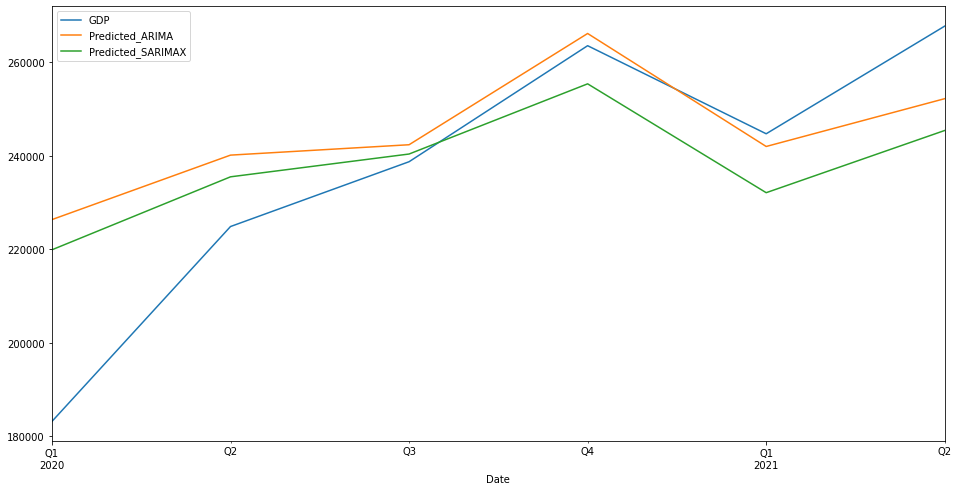

In [39]:
test_data[['GDP', 'Predicted_ARIMA', 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Orbit - Damped Local Trend (DLP) model 

DLT is one of the main exponential smoothing models we support in orbit. Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset (Ng and Wang et al., 2020). The model is a fusion between the classical ETS (Hyndman et. al., 2008)) with some refinement leveraging ideas from Rlgt (Smyl et al., 2019). 


In [40]:
!pip install orbit
!pip install orbit-ml

In [41]:
import orbit
from orbit.models.dlt import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
train_df = train_data[['GDP']].reset_index()

In [43]:
test_df = test_data[['GDP']].reset_index()

In [44]:
date_col = 'Date'
response_col = 'GDP'

In [45]:
train_df.head()

Date    GDP
0 2007-01-01  53480
1 2007-04-01  59217
2 2007-07-01  61099
3 2007-10-01  67399
4 2008-01-01  59640

In [46]:
# Define the DLT model
def createDLT(global_trend_option): 
  return DLT(
      response_col=response_col,
      date_col=date_col,
      seasonality=-1,
      estimator='stan-map',
      seed=8888,
      global_trend_option=global_trend_option, # linear, loglinear, flat, or logistic, 
      # for predicting uncertainty
      n_bootstrap_draws=1000,
  )

In [47]:
dlt_loglinear = createDLT('loglinear')
dlt_loglinear.fit(df=train_df)
predicted_df = dlt_loglinear.predict(df=test_df)

Initial log joint probability = -605.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -551.742       0.20125      0.570457           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -551.659       1.52827   0.000952951           1           1       43   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42      -551.659       2.10744   0.000653861           1           1       47   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [48]:
predicted_df.head()

Date   prediction_5     prediction  prediction_95
0 2020-01-01  213865.969495  233446.572867  254857.298045
1 2020-04-01  216528.606191  238467.008304  260391.764812
2 2020-07-01  218889.624171  242483.349799  269183.351889
3 2020-10-01  217935.761298  245696.415902  275189.614722
4 2021-01-01  216499.204181  248266.861435  281363.482140

In [49]:
prediction = predicted_df[['Date', 'prediction']].set_index('Date')
prediction.head()

prediction
Date                     
2020-01-01  233446.572867
2020-04-01  238467.008304
2020-07-01  242483.349799
2020-10-01  245696.415902
2021-01-01  248266.861435

In [50]:
test_data['Predicted_DLT_LogLinear'] = prediction

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/540110592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DLT_LogLinear'] = prediction


In [51]:
test_data

GDP  Predicted_ARIMA  Predicted_SARIMAX  \
Date                                                     
2020-01-01  183178    226330.295236      219874.040688   
2020-04-01  224847    240114.385632      235474.708928   
2020-07-01  238702    242333.772408      240348.980832   
2020-10-01  263509    266118.815442      255355.416716   
2021-01-01  244679    241962.349695      232082.539610   
2021-04-01  267701    252185.595034      245385.944862   

            Predicted_DLT_LogLinear  
Date                                 
2020-01-01            233446.572867  
2020-04-01            238467.008304  
2020-07-01            242483.349799  
2020-10-01            245696.415902  
2021-01-01            248266.861435  
2021-04-01            250323.210235

In [52]:
dlt_flat = createDLT('flat')
dlt_flat.fit(df=train_df)
predicted_df = dlt_flat.predict(df=test_df)

Initial log joint probability = -606.874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -555.016       1.88232       0.42304           1           1       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -554.991       1.30866    0.00106142      0.7064     0.07064       52   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40      -554.991       2.09058   3.28521e-05           1           1       53   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [53]:
prediction = predicted_df[['Date', 'prediction']].set_index('Date')
prediction.head()

prediction
Date                     
2020-01-01  233446.798298
2020-04-01  238467.301885
2020-07-01  242483.704754
2020-10-01  245696.827049
2021-01-01  248267.324885

In [54]:
test_data['Predicted_DLT_Flat'] = prediction

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/2472618137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DLT_Flat'] = prediction


In [55]:
test_data.head()

GDP  Predicted_ARIMA  Predicted_SARIMAX  \
Date                                                     
2020-01-01  183178    226330.295236      219874.040688   
2020-04-01  224847    240114.385632      235474.708928   
2020-07-01  238702    242333.772408      240348.980832   
2020-10-01  263509    266118.815442      255355.416716   
2021-01-01  244679    241962.349695      232082.539610   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  
Date                                                     
2020-01-01            233446.572867       233446.798298  
2020-04-01            238467.008304       238467.301885  
2020-07-01            242483.349799       242483.704754  
2020-10-01            245696.415902       245696.827049  
2021-01-01            248266.861435       248267.324885

<AxesSubplot:xlabel='Date'>

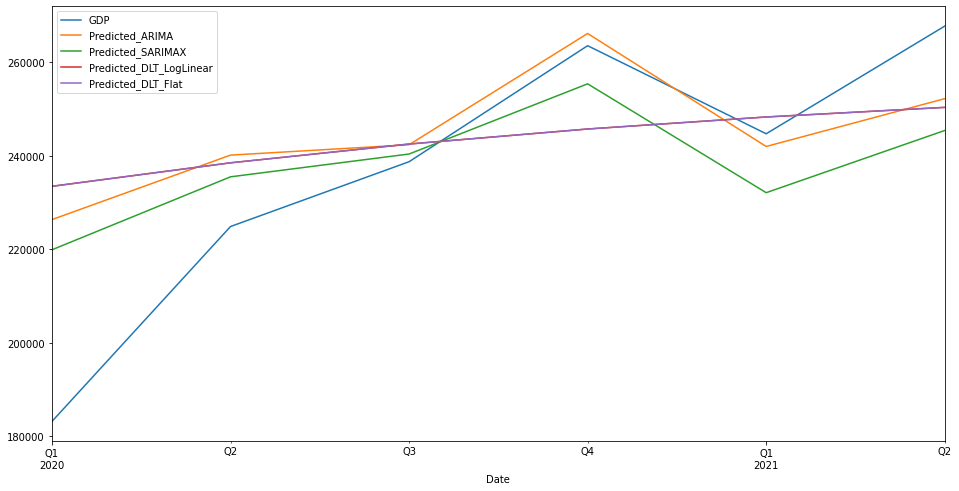

In [56]:
test_data[['GDP', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat']].plot(figsize=(16,8))

## Prophet

In [57]:
!pip install prophet

In [58]:
from prophet import Prophet

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [59]:
train_df.columns

Index(['Date', 'GDP'], dtype='object')

In [60]:
proph_train = train_df.rename(columns={'Date':'ds', 'GDP': 'y'})
proph_test = test_df.rename(columns={'Date':'ds', 'GDP': 'y'})

In [61]:
proph_train.shape, proph_test.shape, train_df.shape, test_df.shape

((52, 2), (6, 2), (52, 2), (6, 2))

In [62]:
m = Prophet()
m.fit(proph_train)
future = m.make_future_dataframe(periods=len(proph_test), freq='QS')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -62.1131
Iteration  1. Log joint probability =    54.6755. Improved by 116.789.
Iteration  2. Log joint probability =    104.783. Improved by 50.1074.
Iteration  3. Log joint probability =    132.203. Improved by 27.4198.
Iteration  4. Log joint probability =    145.372. Improved by 13.1698.
Iteration  5. Log joint probability =    148.291. Improved by 2.91879.
Iteration  6. Log joint probability =    148.905. Improved by 0.613794.
Iteration  7. Log joint probability =    149.014. Improved by 0.108611.
Iteration  8. Log joint probability =    149.086. Improved by 0.0718919.
Iteration  9. Log joint probability =    149.208. Improved by 0.122863.
Iteration 10. Log joint probability =    149.239. Improved by 0.0308943.
Iteration 11. Log joint probability =    149.334. Improved by 0.0952034.
Iteration 12. Log joint probability =     149.38. Improved by 0.0456195.
Iteration 13. Log joint probability =    149.453. Improved by 0.0725682.
Iteration 14. Log join

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [63]:
forecast.head()

ds          trend    yhat_lower    yhat_upper    trend_lower  \
0 2007-01-01  666796.189882  32636.468525  49401.302417  666796.189882   
1 2007-04-01  669394.237348  44069.617886  60164.585158  669394.237348   
2 2007-07-01  672021.152008  48349.264028  65797.291162  672021.152008   
3 2007-10-01  674676.933866  61061.859922  77980.537995  674676.933866   
4 2008-01-01  677332.715727  47778.362426  64325.646048  677332.715727   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  666796.189882  -625825.868987        -625825.868987        -625825.868987   
1  669394.237348  -617183.798157        -617183.798157        -617183.798157   
2  672021.152008  -615118.508370        -615118.508370        -615118.508370   
3  674676.933866  -605048.293292        -605048.293292        -605048.293292   
4  677332.715727  -621266.330866        -621266.330866        -621266.330866   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0 -625825.868987 -625825.868987 -625825.868987                   0.0   
1 -617183.798157 -617183.798157 -617183.798157                   0.0   
2 -615118.508370 -615118.508370 -615118.508370                   0.0   
3 -605048.293292 -605048.293292 -605048.293292                   0.0   
4 -621266.330866 -621266.330866 -621266.330866                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  40970.320895  
1                         0.0                         0.0  52210.439191  
2                         0.0                         0.0  56902.643638  
3                         0.0                         0.0  69628.640574  
4                         0.0                         0.0  56066.384861

In [64]:
forecast.tail()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
53 2020-04-01  856125.448978  234664.753840  251435.869163  856023.643314   
54 2020-07-01  860263.221373  240976.735631  258432.676420  860068.087134   
55 2020-10-01  864446.463794  253657.775774  270410.842449  864123.478496   
56 2021-01-01  868629.706216  232427.086829  249244.643582  868154.309435   
57 2021-04-01  872722.008585  247649.588657  264180.052141  872087.040126   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
53  856197.850476  -612782.716778        -612782.716778        -612782.716778   
54  860419.330173  -611000.167209        -611000.167209        -611000.167209   
55  864700.157012  -602418.422189        -602418.422189        -602418.422189   
56  869013.194593  -628156.952488        -628156.952488        -628156.952488   
57  873235.036051  -616619.362794        -616619.362794        -616619.362794   

           yearly   yearly_lower   yearly_upper  multiplicative_terms  \
53 -612782.716778 -612782.716778 -612782.716778                   0.0   
54 -611000.167209 -611000.167209 -611000.167209                   0.0   
55 -602418.422189 -602418.422189 -602418.422189                   0.0   
56 -628156.952488 -628156.952488 -628156.952488                   0.0   
57 -616619.362794 -616619.362794 -616619.362794                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper           yhat  
53                         0.0                         0.0  243342.732200  
54                         0.0                         0.0  249263.054164  
55                         0.0                         0.0  262028.041606  
56                         0.0                         0.0  240472.753728  
57                         0.0                         0.0  256102.645791

In [65]:
test_data.tail()

GDP  Predicted_ARIMA  Predicted_SARIMAX  \
Date                                                     
2020-04-01  224847    240114.385632      235474.708928   
2020-07-01  238702    242333.772408      240348.980832   
2020-10-01  263509    266118.815442      255355.416716   
2021-01-01  244679    241962.349695      232082.539610   
2021-04-01  267701    252185.595034      245385.944862   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  
Date                                                     
2020-04-01            238467.008304       238467.301885  
2020-07-01            242483.349799       242483.704754  
2020-10-01            245696.415902       245696.827049  
2021-01-01            248266.861435       248267.324885  
2021-04-01            250323.210235       250323.723154

In [66]:
forecast[-6:].shape

(6, 16)

In [67]:
forecast.shape

(58, 16)

In [68]:
test_data.shape

(6, 5)

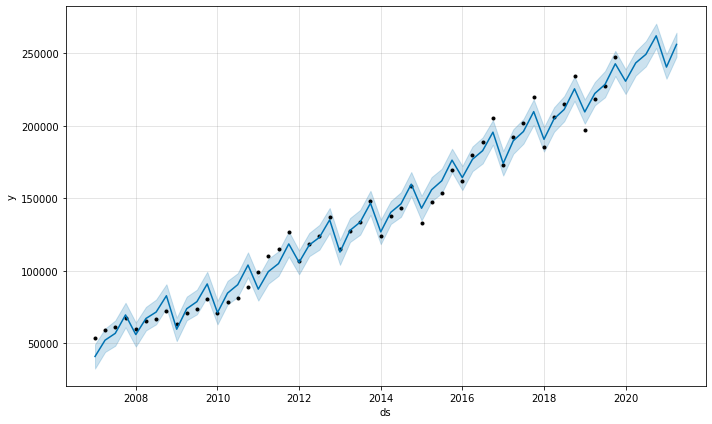

In [69]:
fig1 = m.plot(forecast)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


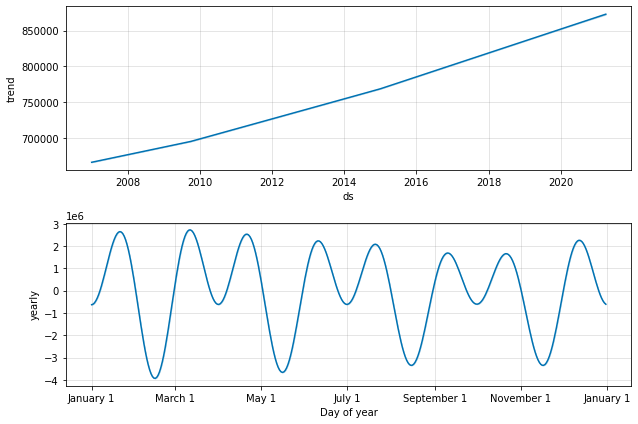

In [70]:
fig2 = m.plot_components(forecast)

In [71]:
test_data['Predicted_Prophet'] = forecast[-6:][['ds', 'yhat']].set_index('ds')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/3719171778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Prophet'] = forecast[-6:][['ds', 'yhat']].set_index('ds')


In [72]:
test_data.head()

GDP  Predicted_ARIMA  Predicted_SARIMAX  \
Date                                                     
2020-01-01  183178    226330.295236      219874.040688   
2020-04-01  224847    240114.385632      235474.708928   
2020-07-01  238702    242333.772408      240348.980832   
2020-10-01  263509    266118.815442      255355.416716   
2021-01-01  244679    241962.349695      232082.539610   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  Predicted_Prophet  
Date                                                                        
2020-01-01            233446.572867       233446.798298      230721.345716  
2020-04-01            238467.008304       238467.301885      243342.732200  
2020-07-01            242483.349799       242483.704754      249263.054164  
2020-10-01            245696.415902       245696.827049      262028.041606  
2021-01-01            248266.861435       248267.324885      240472.753728

<AxesSubplot:xlabel='Date'>

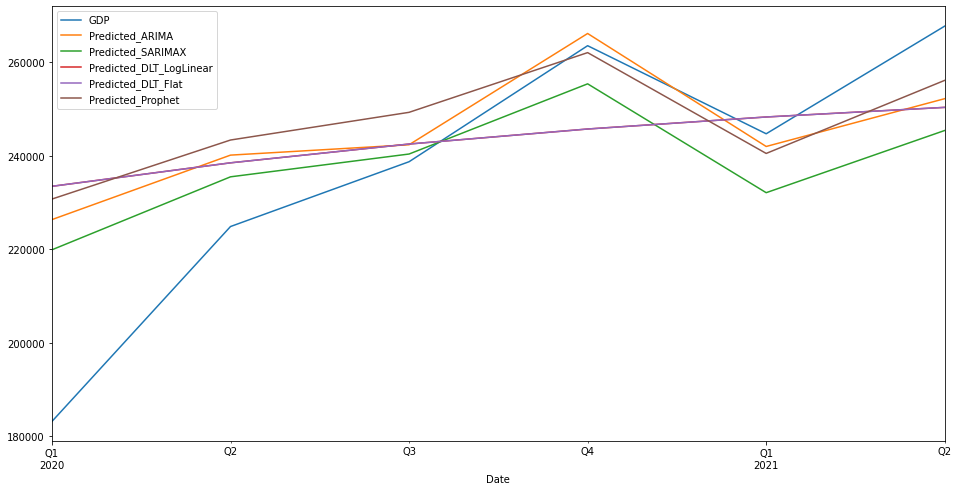

In [73]:
test_data[['GDP', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat', 
           'Predicted_Prophet']].plot(figsize=(16,8))

### DeepAR

In [74]:
df5.shape

(60, 4)

In [75]:
df5.tail()

GDP  GDP differencing  GDP second differencing  \
Date                                                            
2020-10-01  263509           24807.0                  10952.0   
2021-01-01  244679          -18830.0                 -43637.0   
2021-04-01  267701           23022.0                  41852.0   
2021-07-01  277689            9988.0                 -13034.0   
2021-10-01  305703           28014.0                  18026.0   

            GDP yearly differencing  
Date                                 
2020-10-01                  15881.0  
2021-01-01                  61501.0  
2021-04-01                  42854.0  
2021-07-01                  38987.0  
2021-10-01                  42194.0

In [76]:
df5.head()

GDP  GDP differencing  GDP second differencing  \
Date                                                           
2007-01-01  53480               NaN                      NaN   
2007-04-01  59217            5737.0                      NaN   
2007-07-01  61099            1882.0                  -3855.0   
2007-10-01  67399            6300.0                   4418.0   
2008-01-01  59640           -7759.0                 -14059.0   

            GDP yearly differencing  
Date                                 
2007-01-01                      NaN  
2007-04-01                      NaN  
2007-07-01                      NaN  
2007-10-01                      NaN  
2008-01-01                   6160.0

In [77]:
train_data.head()

GDP
Date             
2007-01-01  53480
2007-04-01  59217
2007-07-01  61099
2007-10-01  67399
2008-01-01  59640

In [78]:
start = pd.Timestamp("2007-01-01", freq="Q")
train_ds = ListDataset([{'target': train_data.GDP, 'start': start}], freq='Q')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/640928001.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2007-01-01", freq="Q")


Test dataset: use the whole dataset, add 'target' and 'start' field

In [79]:
test_ds = ListDataset([{'target': df5.GDP, 'start': start}], freq='Q')

In [92]:
np.random.seed(42)
mx.random.seed(42)

estimator = DeepAREstimator(
    prediction_length=6,
    context_length=4,
    freq='Q',
    trainer=Trainer( # ctx="gpu",
                    epochs=25, learning_rate=1e-3, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/time

In [93]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

In [94]:
test_df.head()

Date     GDP
0 2020-01-01  183178
1 2020-04-01  224847
2 2020-07-01  238702
3 2020-10-01  263509
4 2021-01-01  244679

In [95]:
pred_df = pd.DataFrame(predictions)
pred_df.columns = ['Pred_GDP']
pred_df

Pred_GDP
0  253557.00000
1  283116.25000
2  295139.53125
3  323896.21875
4  268584.43750
5  298522.37500

In [96]:
test_data['Predicted_DeepAR'] = pd.concat([test_df.Date, pred_df], axis=1).set_index('Date')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_2662/3866931146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DeepAR'] = pd.concat([test_df.Date, pred_df], axis=1).set_index('Date')


<AxesSubplot:xlabel='Date'>

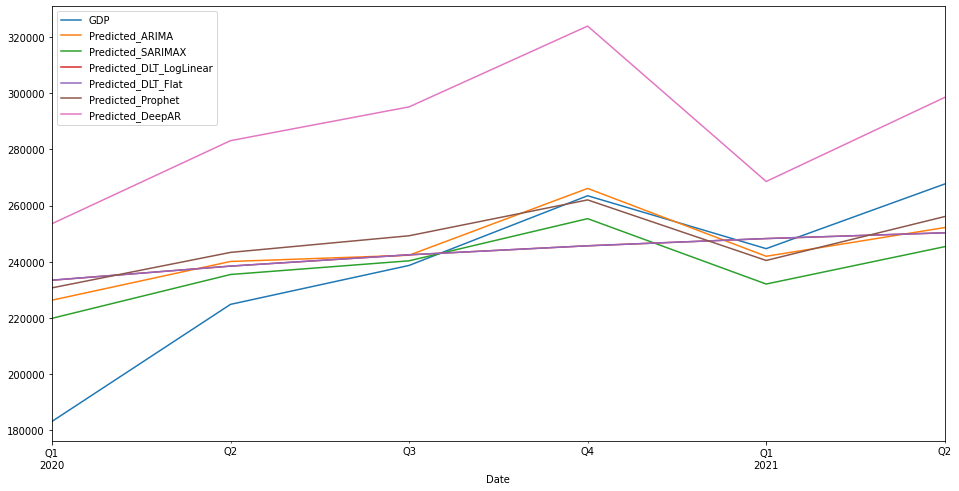

In [97]:
test_data[['GDP', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat', 
           'Predicted_Prophet', 'Predicted_DeepAR']].plot(figsize=(16,8))

## Metrics

In [98]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 393887089.28787833
Mean Absolute Error is : 13815.553998057265
Root Mean Square Error is : 19846.588857732666
Mean Absolute Percentage Error is : 6.627610139417918
R2 score is : 0.5026240844573574



In [99]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 364228927.6084605
Mean Absolute Error is : 15339.304876735861
Root Mean Square Error is : 19084.78261884218
Mean Absolute Percentage Error is : 7.0046355892034216
R2 score is : 0.5400745511514586



In [100]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_DLT_LogLinear)

Evaluation metric results:-
Mean Square Error is : 559813521.5989875
Mean Absolute Error is : 17741.36104457441
Root Mean Square Error is : 23660.37872898461
Mean Absolute Percentage Error is : 8.300278110879454
R2 score is : 0.29310259104495084



In [101]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_DLT_Flat)

Evaluation metric results:-
Mean Square Error is : 559814221.3180573
Mean Absolute Error is : 17741.429936423097
Root Mean Square Error is : 23660.393515705888
Mean Absolute Percentage Error is : 8.300318797612787
R2 score is : 0.2931017074835891



In [102]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 478067543.7224018
Mean Absolute Error is : 15647.615159084127
Root Mean Square Error is : 21864.755743488236
Mean Absolute Percentage Error is : 7.5364485425615095
R2 score is : 0.3963262855859505



In [103]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_DeepAR)

Evaluation metric results:-
Mean Square Error is : 2783624559.5791016
Mean Absolute Error is : 50033.302083333336
Root Mean Square Error is : 52760.065955029866
Mean Absolute Percentage Error is : 22.029953934537904
R2 score is : -2.514986531675204



### Conclusion:

The best model to predict China Real GDP is the ARIMA model as it give the smallest MSE and MAE. Also the R2 score at 0.50 positive means we could trust the result. 